In [1]:
import saspy
sas = saspy.SASsession()

Using SAS Config named: oda
SAS Connection established. Subprocess id is 20776



### bar


In [6]:
sas.sasdata('cars', 'sashelp').head()

,Make,Model,Type,Origin,DriveTrain,MSRP,Invoice,EngineSize,Cylinders,Horsepower,MPG_City,MPG_Highway,Weight,Wheelbase,Length
0,Acura,MDX,SUV,Asia,All,36945.0,33337.0,3.5,6.0,265.0,17.0,23.0,4451.0,106.0,189.0
1,Acura,RSX Type S 2dr,Sedan,Asia,Front,23820.0,21761.0,2.0,4.0,200.0,24.0,31.0,2778.0,101.0,172.0
2,Acura,TSX 4dr,Sedan,Asia,Front,26990.0,24647.0,2.4,4.0,200.0,22.0,29.0,3230.0,105.0,183.0
3,Acura,TL 4dr,Sedan,Asia,Front,33195.0,30299.0,3.2,6.0,270.0,20.0,28.0,3575.0,108.0,186.0
4,Acura,3.5 RL 4dr,Sedan,Asia,Front,43755.0,39014.0,3.5,6.0,225.0,18.0,24.0,3880.0,115.0,197.0



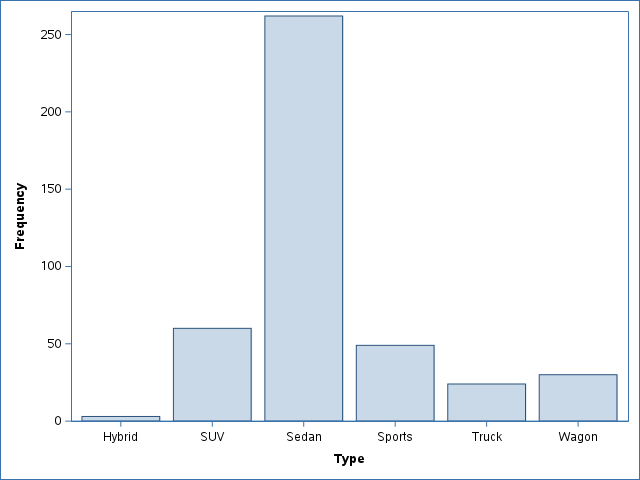

In [14]:
sas.submitLST(
f"""
proc sgplot data=sashelp.cars;
    var Type;
run;
""")

### options


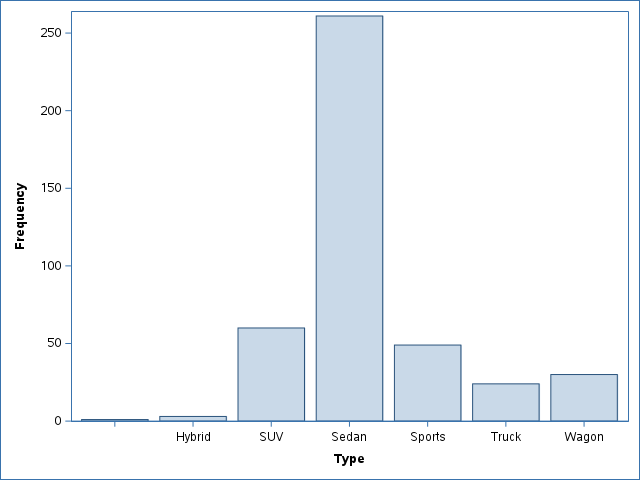

In [15]:
# missing
sas.submitLST(f"""
    data cars;
        set sashelp.cars;
        if strip(model) in ('TSX 4dr', 'TL 4dr', 'MDX') then do;
            msrp = .;
            invoice = .;
            mpg_city = .;
            mpg_highway = .;
        end;
        if strip(model) in ('3.5 RL 4dr') then do;
            type = '';
            origin = '';
        end;
        keep model type origin msrp invoice mpg_city mpg_highway;
    run;

    proc sgplot data=cars;
        vbar type / missing;
    run;
""")


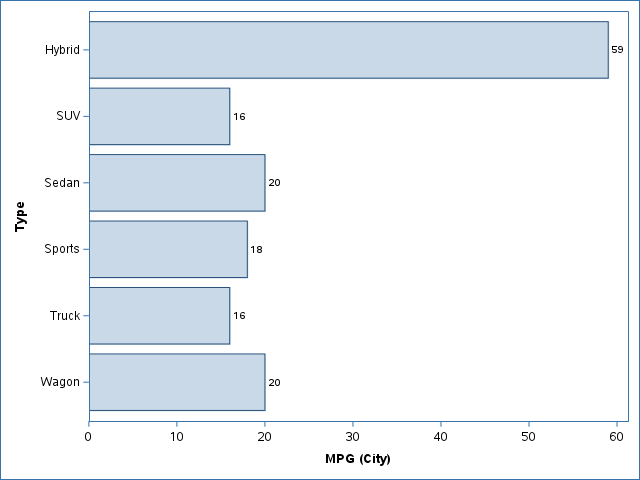

In [16]:
# response and stat
sas.submitLST(f"""
    proc sgplot data=sashelp.cars;
        hbar type / missing response=mpg_city stat=median datalabel;
    run;
""")


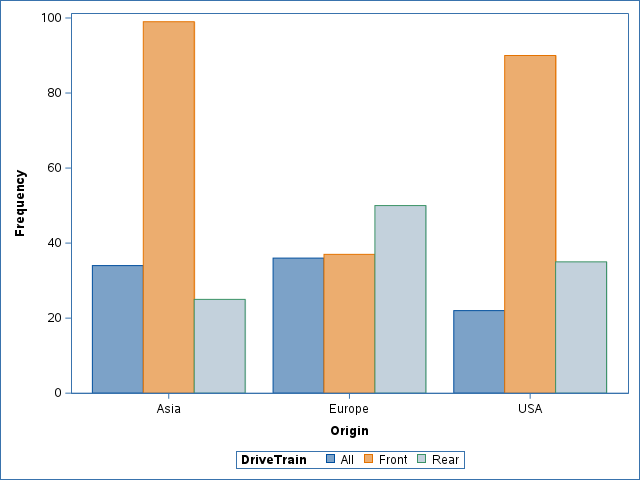

In [10]:
# group
sas.submitLST(f"""
    proc sgplot data=sashelp.cars;
        vbar origin / group=driveTrain groupdisplay=cluster;
    run;
""")


In [3]:
sas.submitLST(f"""
    proc freq data=sashelp.cars;
        tabels origin * driveTrain / nocum norow nocol;
    run;
""")



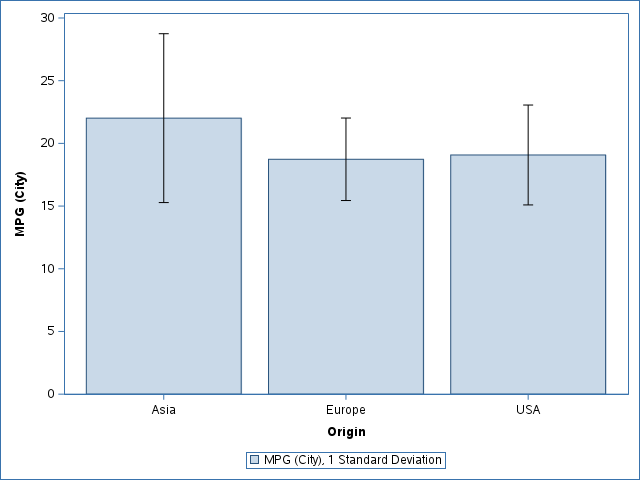

In [23]:
# limitstat
sas.submitLST(
f"""
proc sgplot data=sashelp.cars;
    var origin / response=mpg_city stat=mean limitstat=stddev;
run;
""")


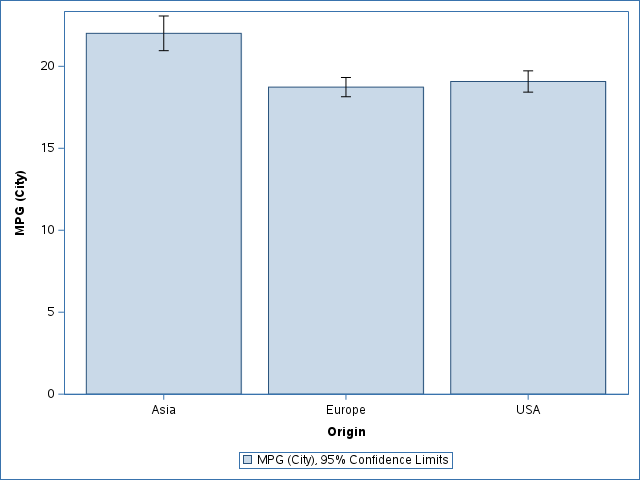

In [24]:
sas.submitLST(
f"""
proc sgplot data=sashelp.cars;
    var origin / response=mpg_city stat=mean limitstat=clm;
run;
""")

### bar and line

In [2]:
sas.submitLST(
f"""
/* Compute axis ranges */
proc means data=SASHELP.CARS noprint;
	class Type / order=data;
	var MPG_City MPG_Highway;
	output out=_BarLine_(where=(_type_ > 0)) mean(MPG_City MPG_Highway)=resp1 
		resp2;
run;

/* Compute response min and max values (include 0 in computations) */
data _null_;
	retain respmin 0 respmax 0;
	retain respmin1 0 respmax1 0 respmin2 0 respmax2 0;
	set _BarLine_ end=last;
	respmin1=min(respmin1, resp1);
	respmin2=min(respmin2, resp2);
	respmax1=max(respmax1, resp1);
	respmax2=max(respmax2, resp2);

	if last then
		do;
			call symputx ("respmin1", respmin1);
			call symputx ("respmax1", respmax1);
			call symputx ("respmin2", respmin2);
			call symputx ("respmax2", respmax2);
			call symputx ("respmin", min(respmin1, respmin2));
			call symputx ("respmax", max(respmax1, respmax2));
		end;
run;

/* Define a macro for offset */
%macro offset ();
	%if %sysevalf(&respmin eq 0) %then
		%do;
			offsetmin=0 %end;

	%if %sysevalf(&respmax eq 0) %then
		%do;
			offsetmax=0 %end;
%mend offset;

ods graphics / reset width=6.4in height=4.8in imagemap;

proc sgplot data=SASHELP.CARS nocycleattrs;
	title height=14pt "mean mileage by type";
	vbar Type / response=MPG_City fillattrs=(color=CXa70000) stat=mean;
	vline Type / response=MPG_Highway lineattrs=(thickness=10) stat=mean y2axis;
	xaxis display=(nolabel);
	yaxis grid min=&respmin1 max=&respmax1 %offset();
	y2axis min=&respmin2 max=&respmax2 %offset();
	keylegend / location=outside;
run;

ods graphics / reset;
title;

proc datasets library=WORK noprint;
	delete _BarLine_;
	run;
""")